# Maximum-Cut Problem using Variants of Quantum Approximate Optimization Algorithm (QAOA), a small illustration of QiboOpt

## Maximum-Cut Problem


The **Maximum-Cut Problem** (MCP) can be stated as follows:

> Given a graph G = (V, E) with vertices V and edges E (possibly weighted), the Maximum-Cut Problem seeks to divide the set of verticies into two complementary subsets such that the total weight (or number) of edges between these subsets is maximised.

### Key Points:

1. **Combinatorial Nature:** For a graph with $n$ nodes, there are $2^{n-1} - 1$ possible unique cuts (since swapping the two sets produces the same cut). This exonential growth makes MCP computtionally hard for large $n$.

2. **Applications:**
    - **Machine Learning:**  
  The Maximum-Cut Problem (MCP) can be reformulated as an optimisation over binary variables, making it useful for tasks such as binary classification and clustering.

    - **Statistical / Theoretical Physics:**  
  MCP is closely related to minimising the **Hamiltonian** of spin glass systems.  
  *By negating the edge weights, a minimisation problem can be transformed into a maximisation one — and vice versa.*

    - **Network Design & Circuit Layout:**  
  It also arises in applications such as community detection, VLSI (Very Large-Scale Integration) circuit layout optimisation, and social network analysis.


3. **Optimisation Goal:** The objective is to maximise the total weight of the edges crossing the cut.

Here is a $5$-person example where we must split people into two groups to minimise within-group conflict. Equivalently, to maximise the total “conflict” cut. We model pairwise incompatibility with a symmetric weight matrix $W$ (higher = more tension), i.e. an undirected weighted graph:

$$
\mathbf{W} =
\begin{bmatrix}
0 & 0.2 & 0.8 & 0.8 & 0.8 \\
0.2 & 0 & 0.8 & 0.8 & 0.8 \\
0.8 & 0.8 & 0 & 0.2 & 0.2 \\
0.8 & 0.8 & 0.2 & 0 & 0.2 \\
0.8 & 0.8 & 0.2 & 0.2 & 0
\end{bmatrix}
$$

The $(i,j)$ entry gives the incompatibility between people $i$ and $j$. It is important to note that the matrix has zero diagonal and is symmetric $(W_{ij} = W_{ji})$.

Let's visualise this:

In [56]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

dist_matrix = np.array([
    [0, 0.2, 0.8, 0.8, 0.8],
    [0.2, 0, 0.8, 0.8, 0.8],
    [0.8, 0.8, 0, 0.2, 0.2],
    [0.8, 0.8, 0.2, 0, 0.2],
    [0.8, 0.8, 0.2, 0.2, 0]
])



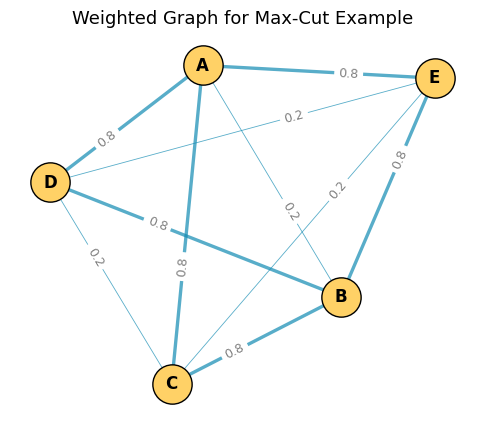

In [57]:
# Create a weighted undirected graph from the matrix
G = nx.from_numpy_array(dist_matrix)

# Relabel nodes (A,B,C,D,E)
mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E'}
mapping = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E'}
G = nx.relabel_nodes(G, mapping)

# Draw nodes and edges
pos = nx.spring_layout(G, seed=42, weight='weight', k=0.6)
plt.figure(figsize=(6, 5))
nx.draw_networkx_nodes(G, pos, node_color='#ffd166', node_size=800, edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Edge widths and colors proportional to weights
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw_networkx_edges(
    G, 
    pos, 
    width=[3*w for w in weights], 
    alpha=0.7, 
    edge_color='#118ab2'
    )

# Label edges with weights
edge_labels = {(u,v): f"{G[u][v]['weight']:.1f}" for u,v in G.edges()}
nx.draw_networkx_edge_labels(
    G, 
    pos, 
    edge_labels=edge_labels, 
    font_size=9, 
    font_color='gray',
    label_pos=0.64 
    )

# Output Graph
plt.title("Weighted Graph for Max-Cut Example", fontsize=13)
plt.axis('off')
plt.show()


By splitting the verticies into the sets $S = \{A, B\}$ and $S' = \{C, D, E\}$, the edges with the higher values (0.8) are cut. This configuration therefore yields a maximum cut, as it maximises the total weight of edges crossing between the two subsets.

In this tutorial, we will explore a similar max-cut instance and demostrate that the optimal partition can be identified in a small, illustrative example using the Quantum Approximate Optimisation Algorithm. This serves as a proof-of-concept showing how MCP can be formulated as a QUBO using Qibo.

## Encoding of the Maximum Cut Objective as a Quadratic Unconstrained Binary Optimisation (QUBO) Problem

The Maximum-Cut problem can be encoded as a Quadratic Unconstrained Binary Optimisation (QUBO) problem. 

Consider a graph  $G = (V, E)$ with vertex set $V$ and weighted edges $w_{uv}$. We assign to each vertex $u \in V$ a binary variable $x_u \in \set {0, 1}$, which encodes the subset to which the vertex belongs. For example, $x_u = 0$ if the vertex is in set $S$, and $x_u = 1$ if it is in the complementary set $S'$.

An edge $(u, v)$ is said to be cut if its endpoints lie in different subsets: if $x_u \neq x_v$. The total weight of the cut can then be written as

$$C(x) = \frac{1}{2} \sum_{(u,v)\in E} w_{uv}(x_u-x_v)^2 $$

This quadratic expression naturally defines the QUBO objective for Max-Cut, as it is a function solely of binary variables. The goal is to find the binary assignment {$x_u$} that maximises $C(x)$ thereby maximising the total weight of the edges that are cut.

Using the same approach introduced by Hadfield [4], the Quantum Approximate Optimization Algorithm (QAOA) can be employed to solve this formulation on quantum hardware. In Qibo, this encoding is implemented through a Max-Cut class, which allows us to specify the graph weights directly and construct the corresponding QUBO Hamiltonian automatically.

In [58]:
from qiboopt.combinatorial.combinatorial import MaxCut
from matplotlib.lines import Line2D
from collections import defaultdict
from qibo import gates
from qibo.models import QAOA
from qibo.result import CircuitResult
from qibo.models.circuit import Circuit


# Build Max-Cut instance (you can also pass networkx Graph 'G' directly)
mc = MaxCut(dist_matrix, backend=None, normalize='maxdeg', mixer='xy')
obj_h, mix_h = mc.hamiltonians()

# Prepare initial state and run QAOA
init_state = mc.prepare_initial_state(init="plus")
p = 2  # QAOA depth
qaoa = QAOA(obj_h, mixer=mix_h)
best_E, params, _ = qaoa.minimize(initial_p=[0.2]*p, initial_state=init_state, method='BFGS')
qaoa.set_parameters(params)

# Evolved state
state = qaoa.execute(init_state)

# Sample bitstrings
n = mc.n
# n = 5
c = Circuit(n)
c.add(gates.M(*range(n)))
res = CircuitResult(state, c.measurements, mc.backend, nshots=100000)
freqs = res.frequencies()

# Pick most frequent bitstring and evaluate cut
best_bits = max(freqs, key=freqs.get)
best_cut_true = mc.cut_value(best_bits, use_scaled=False)
S, Sp = mc.partition_from_bits(best_bits)

print(f"Best bitstring: {best_bits} (count={freqs[best_bits]})")
print(f"Cut weight (true units): {best_cut_true:.3f}")
print(f"Partition: S={sorted(S)}, S'={sorted(Sp)}")

Best bitstring: 10110 (count=6595)
Cut weight (true units): 3.000
Partition: S=[1, 4], S'=[0, 2, 3]


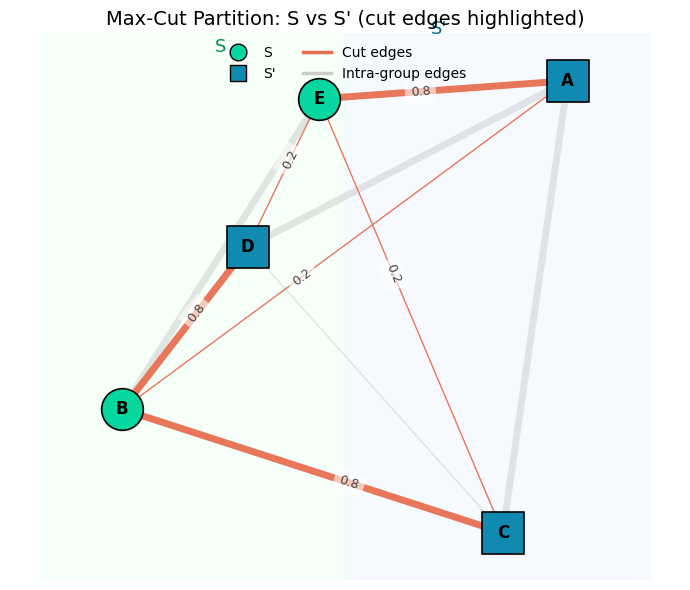

In [59]:


# Visualize partition on the same layout 'pos' and graph 'G'


# Ensure S and Sp exist (from earlier QAOA result), and G/pos are defined.
# If MaxCut was built from a matrix (S, Sp as ints) but G was relabeled (A..E),
# use the same 'mapping' you used to relabel the graph.
try:
    if len(S) and isinstance(next(iter(S)), int):
        sample_node = next(iter(G.nodes()))
        if not isinstance(sample_node, int) and 'mapping' in globals():
            S  = {mapping[i] for i in S}
            Sp = {mapping[i] for i in Sp}
except Exception:
    pass

# Base layout: reuse existing 'pos' if it exists; else compute one
if 'pos' not in globals():
    pos = nx.spring_layout(G, seed=42, weight='weight')

# Create horizontally separated layout
sep = 0.9  # horizontal separation amount
pos2 = {}
for n in G.nodes():
    x, y = pos[n]
    if n in S:
        pos2[n] = (x - sep, y)
    elif n in Sp:
        pos2[n] = (x + sep, y)
    else:
        pos2[n] = (x, y)  # fallback for any stray nodes

# Partition edges into cut vs intra-group
def is_cut(u, v): 
    return (u in S and v in Sp) or (u in Sp and v in S)

edges = list(G.edges())
weights = np.array([G[u][v].get('weight', 1.0) for u, v in edges], dtype=float)
wmin, wmax = (weights.min() if len(weights) else 1.0), (weights.max() if len(weights) else 1.0)
widths = 1.0 + 4.0 * (weights - wmin) / (wmax - wmin + 1e-9)

mask_cut = np.array([is_cut(u, v) for u, v in edges], dtype=bool)
edges_cut = [e for e, m in zip(edges, mask_cut) if m]
edges_in  = [e for e, m in zip(edges, mask_cut) if not m]
widths_cut = widths[mask_cut] if len(edges) else []
widths_in  = widths[~mask_cut] if len(edges) else []

# Background shading for groups
xs = [xy[0] for xy in pos2.values()]
xmin, xmax = min(xs) - 0.2, max(xs) + 0.2
xmid = 0.5 * (xmin + xmax)

fig, ax = plt.subplots(figsize=(7, 6))
ax.axvspan(xmin, xmid, color='#f0fff4', alpha=0.55, zorder=0)  # left group background
ax.axvspan(xmid, xmax, color='#f0f7ff', alpha=0.55, zorder=0)  # right group background

# Draw nodes with distinct shapes/colors
nodes_S  = list(S)
nodes_Sp = list(Sp)

nx.draw_networkx_nodes(G, pos2, nodelist=nodes_S,  node_color='#06d6a0', node_shape='o',
                       node_size=900, edgecolors='black', linewidths=1.2, ax=ax)
nx.draw_networkx_nodes(G, pos2, nodelist=nodes_Sp, node_color='#118ab2', node_shape='s',
                       node_size=900, edgecolors='black', linewidths=1.2, ax=ax)

nx.draw_networkx_labels(G, pos2, font_size=12, font_weight='bold', ax=ax)

# Draw intra-group edges (light) and cut edges (highlighted)
nx.draw_networkx_edges(G, pos2, edgelist=edges_in, width=widths_in,
                       alpha=0.25, edge_color='#9e9e9e', ax=ax)
nx.draw_networkx_edges(G, pos2, edgelist=edges_cut, width=widths_cut,
                       alpha=0.95, edge_color='#e76f51', ax=ax)

# Label only cut edges to reduce clutter (toggle to edges for all)
edge_labels_cut = {(u, v): f"{G[u][v].get('weight', 1.0):.1f}" for (u, v) in edges_cut}
nx.draw_networkx_edge_labels(G, pos2, edge_labels=edge_labels_cut, font_size=9,
                             font_color='#444', bbox=dict(facecolor='white', edgecolor='none', alpha=0.6),
                             label_pos=0.6, ax=ax)

# Legends
legend_nodes = [
    Line2D([0], [0], marker='o', color='w', label="S", markerfacecolor='#06d6a0',
           markeredgecolor='black', markersize=12),
    Line2D([0], [0], marker='s', color='w', label="S'", markerfacecolor='#118ab2',
           markeredgecolor='black', markersize=12),
]
legend_edges = [
    Line2D([0], [0], color='#e76f51', lw=2.5, label='Cut edges'),
    Line2D([0], [0], color='#9e9e9e', lw=2.5, alpha=0.5, label='Intra-group edges'),
]
ax.legend(handles=legend_nodes + legend_edges, loc='upper center', ncol=2, frameon=False)

# Optional group labels
if nodes_S:
    sx = np.mean([pos2[n][0] for n in nodes_S]); sy = max([pos2[n][1] for n in nodes_S]) + 0.15
    ax.text(sx, sy, "S", fontsize=13, color='#048a63', ha='center', va='bottom')
if nodes_Sp:
    tx = np.mean([pos2[n][0] for n in nodes_Sp]); ty = max([pos2[n][1] for n in nodes_Sp]) + 0.15
    ax.text(tx, ty, "S'", fontsize=13, color='#0b6691', ha='center', va='bottom')

ax.set_title("Max-Cut Partition: S vs S' (cut edges highlighted)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [60]:
# Baseline + robust QAOA selection
import itertools, numpy as np
from qibo.models import QAOA

def brute_force_best(mc):
    best_val, best_bits = -1.0, None
    for bits in itertools.product([0,1], repeat=mc.n):
        v = mc.cut_value(bits)
        if v > best_val:
            best_val, best_bits = v, bits
    return best_bits, best_val

def qaoa_run(mc, p=2, restarts=12, method="BFGS"):
    obj_h, mix_h = mc.hamiltonians()
    init_state = mc.prepare_initial_state(init="plus")
    qaoa = QAOA(obj_h, mixer=mix_h)
    bestE, bestParams = float("inf"), None
    for _ in range(restarts):
        init_p = np.random.uniform(0.0, 0.6, size=2*p)
        E, params, _ = qaoa.minimize(initial_p=init_p, initial_state=init_state, method=method)
        if E < bestE:
            bestE, bestParams = E, params
    qaoa.set_parameters(bestParams)
    state = qaoa.execute(init_state)
    return qaoa, state

# Build with stable defaults
# mc = MaxCut(G, normalize='maxdeg', mixer='x')  # prefer G so labels match
qaoa, state = qaoa_run(mc, p=3, restarts=12)

# Sample and pick by cut value
from qibo import gates
from qibo.models.circuit import Circuit
from qibo.result import CircuitResult

c = Circuit(mc.n); c.add(gates.M(*range(mc.n)))
res = CircuitResult(state, c.measurements, mc.backend, nshots=4000)
freqs = res.frequencies()

top = sorted(freqs.items(), key=lambda kv: kv[1], reverse=True)[:32]
best_bits, best_val = max(top, key=lambda kv: mc.cut_value(kv[0]))
print("QAOA best (top-32):", best_bits, "cut=", mc.cut_value(best_bits))

# Baseline (if n small)
if mc.n <= 15:
    bf_bits, bf_val = brute_force_best(mc)
    print("Brute force best:", bf_bits, "cut=", bf_val)


QAOA best (top-32): 11010 cut= 3.6000000000000005
Brute force best: (0, 0, 1, 1, 1) cut= 4.8
